In [411]:
# Author: Banafsheh Khazali
# Date: June 5, 2023

Step 3, Systematically destroying the network

In [412]:
import time
import os

import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import integrate, signal, sparse, linalg
from threading import Thread


In [413]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [414]:
""" Number of Neurons """
N = 279

""" Cell membrane conductance (pS) """
Gc = 0.1

""" Cell Membrane Capacitance """
C = 0.015

""" Gap Junctions (Electrical, 279*279) """
ggap = 1.0
Gg_Static = np.load('/content/drive/MyDrive/connectome/Gg.npy')

""" Synaptic connections (Chemical, 279*279) """
gsyn = 1.0
Gs_Static = np.load('/content/drive/MyDrive/connectome/Gs.npy')

""" Leakage potential (mV) """
Ec = -35.0

""" Directionality (279*1) """
E = np.load('/content/drive/MyDrive/connectome/emask.npy')
E = -48.0 * E
EMat = np.tile(np.reshape(E, N), (N, 1))

""" Synaptic Activity Parameters """
ar = 1.0/1.5 # Synaptic activity's rise time
ad = 5.0/1.5 # Synaptic activity's decay time
B = 0.125 # Width of the sigmoid (mv^-1)

""" Input_Mask/Continuous Transtion """
transit_Mat = np.zeros((2, N))

t_Tracker = 0
Iext = 100000

rate = 0.025
offset = 0.15

t_Switch = 0
transit_End = 10

In [415]:
""" Connectome Arrays """
Gg_Dynamic = Gg_Static.copy()
Gs_Dynamic = Gs_Static.copy()

""" Data matrix stack size """
stack_Size = 5
init_data_Mat = np.zeros((stack_Size + 50, N))
data_Mat = np.zeros((stack_Size, N))

# """ Directory paths for presets """
# default_Dir = os.getcwd()
# preset_Dir = default_Dir + '/presets'
# save_Dir = default_Dir + '/saved_dynamics'
InMask = np.zeros(N)
oldMask = np.zeros(N)
newMask = np.zeros(N)

#find the location of two 
indices = [196, 198]
value = 3.4
newMask[indices] = value




In [416]:
""" Mask transition """
def transit_Mask(input_Array):

    global t_Switch, oldMask, newMask, transit_End, Vth_Static

    transit_Mat[0,:] = transit_Mat[1,:]

    t_Switch = t_Tracker

    transit_Mat[1,:] = input_Array

    oldMask = transit_Mat[0,:]
    newMask = transit_Mat[1,:]

    Vth_Static = EffVth_rhs(Iext, newMask)
    transit_End = t_Switch + 0.3

    print(oldMask, newMask, t_Switch, transit_End)

In [417]:
def update_Mask(old, new, t, tSwitch):

    return np.multiply(old, 0.5-0.5*np.tanh((t-tSwitch)/rate)) + np.multiply(new, 0.5+0.5*np.tanh((t-tSwitch)/rate))

In [418]:
""" Ablation """
def modify_Connectome(ablation_Array):

    global Vth_Static, Gg_Dynamic, Gs_Dynamic

    apply_Col = np.tile(ablation_Array, (N, 1))
    apply_Row = np.transpose(apply_Col)

    apply_Mat = np.multiply(apply_Col, apply_Row)

    Gg_Dynamic = np.multiply(Gg_Static, apply_Mat)
    Gs_Dynamic = np.multiply(Gs_Static, apply_Mat)

    try:
        newMask

    except NameError:

        EffVth(Gg_Dynamic, Gs_Dynamic)

        if np.sum(ablation_Array) != N:

            print("Neurons " + str(np.where(ablation_Array == False)[0]) + " are ablated")

        else:

            print("All Neurons healthy")

        print("EffVth Recalculated")

    else:

        EffVth(Gg_Dynamic, Gs_Dynamic)
        Vth_Static = EffVth_rhs(Iext, newMask)

        if np.sum(ablation_Array) != N:

            print("Neurons " + str(np.where(ablation_Array == False)[0]) + " are ablated") 

        else:

            print("All Neurons healthy")

        print("EffVth Recalculated")
        print("Vth Recalculated")


In [419]:
""" Efficient V-threshold computation """
def EffVth(Gg, Gs):

    Gcmat = np.multiply(Gc, np.eye(N))
    EcVec = np.multiply(Ec, np.ones((N, 1)))

    M1 = -Gcmat
    b1 = np.multiply(Gc, EcVec)

    Ggap = np.multiply(ggap, Gg)
    Ggapdiag = np.subtract(Ggap, np.diag(np.diag(Ggap)))
    Ggapsum = Ggapdiag.sum(axis = 1)
    Ggapsummat = sparse.spdiags(Ggapsum, 0, N, N).toarray()
    M2 = -np.subtract(Ggapsummat, Ggapdiag)

    Gs_ij = np.multiply(gsyn, Gs)
    s_eq = round((ar/(ar + 2 * ad)), 4)
    sjmat = np.multiply(s_eq, np.ones((N, N)))
    S_eq = np.multiply(s_eq, np.ones((N, 1)))
    Gsyn = np.multiply(sjmat, Gs_ij)
    Gsyndiag = np.subtract(Gsyn, np.diag(np.diag(Gsyn)))
    Gsynsum = Gsyndiag.sum(axis = 1)
    M3 = -sparse.spdiags(Gsynsum, 0, N, N).toarray()

    b3 = np.dot(Gs_ij, np.multiply(s_eq, E))

    M = M1 + M2 + M3

    global LL, UU, bb

    (P, LL, UU) = linalg.lu(M)
    bbb = -b1 - b3
    bb = np.reshape(bbb, N)



In [420]:
def EffVth_rhs(Iext, InMask):

    InputMask = np.multiply(Iext, InMask)
    b = np.subtract(bb, InputMask)

    Vth = linalg.solve_triangular(UU, linalg.solve_triangular(LL, b, lower = True, check_finite=False), check_finite=False)

    return Vth


In [421]:
def voltage_filter(v_vec, vmax, scaler):
    
    filtered = vmax * np.tanh(scaler * np.divide(v_vec, vmax))
    
    return filtered

In [422]:
""" Right hand side """
def membrane_voltageRHS(t, y):
    global InMask, Vth, t_switch, transit_End

    """ Split the incoming values """
    Vvec, SVec = np.split(y, 2)

    """ Gc(Vi - Ec) """
    VsubEc = np.multiply(Gc, (Vvec - Ec))

    """ Gg(Vi - Vj) Computation """
    Vrep = np.tile(Vvec, (N, 1))
    GapCon = np.multiply(Gg_Dynamic, np.subtract(np.transpose(Vrep), Vrep)).sum(axis = 1)

    """ Gs*S*(Vi - Ej) Computation """
    VsubEj = np.subtract(np.transpose(Vrep), EMat)
    SynapCon = np.multiply(np.multiply(Gs_Dynamic, np.tile(SVec, (N, 1))), VsubEj).sum(axis = 1)

    global InMask, Vth

    if t >= t_Switch and t <= transit_End:

        InMask = update_Mask(oldMask, newMask, t, t_Switch + offset)
        Vth = EffVth_rhs(Iext, InMask)

    else:

        InMask = newMask
        Vth = Vth_Static

    """ ar*(1-Si)*Sigmoid Computation """
    SynRise = np.multiply(np.multiply(ar, (np.subtract(1.0, SVec))),
                          np.reciprocal(1.0 + np.exp(-B*(np.subtract(Vvec, Vth)))))

    SynDrop = np.multiply(ad, SVec)

    """ Input Mask """
    Input = np.multiply(Iext, InMask)

    """ dV and dS and merge them back to dydt """
    dV = (-(VsubEc + GapCon + SynapCon) + Input)/C
    dS = np.subtract(SynRise, SynDrop)

    return np.concatenate((dV, dS))


In [423]:
def compute_jacobian(t, y):

    Vvec, SVec = np.split(y, 2)
    Vrep = np.tile(Vvec, (N, 1))

    J1_M1 = -np.multiply(Gc, np.eye(N))
    Ggap = np.multiply(ggap, Gg_Dynamic)
    Ggapsumdiag = -np.diag(Ggap.sum(axis = 1))
    J1_M2 = np.add(Ggap, Ggapsumdiag) 
    Gsyn = np.multiply(gsyn, Gs_Dynamic)
    J1_M3 = np.diag(np.dot(-Gsyn, SVec))

    J1 = (J1_M1 + J1_M2 + J1_M3) / C

    J2_M4_2 = np.subtract(EMat, np.transpose(Vrep))
    J2 = np.multiply(Gsyn, J2_M4_2) / C

    global InMask, Vth

    if t >= t_Switch and t <= transit_End:

        InMask = update_Mask(oldMask, newMask, t, t_Switch + offset)
        Vth = EffVth_rhs(Iext, InMask)

    else:

        InMask = newMask
        Vth = Vth_Static

    sigmoid_V = np.reciprocal(1.0 + np.exp(-B*(np.subtract(Vvec, Vth))))
    J3_1 = np.multiply(ar, 1 - SVec)
    J3_2 = np.multiply(B, sigmoid_V)
    J3_3 = 1 - sigmoid_V
    J3 = np.diag(np.multiply(np.multiply(J3_1, J3_2), J3_3))

    J4 = np.diag(np.subtract(np.multiply(-ar, sigmoid_V), ad))

    J_row1 = np.hstack((J1, J2))
    J_row2 = np.hstack((J3, J4))
    J = np.vstack((J_row1, J_row2))

    return J



In [424]:
def run_Network(t_Delta, atol):
    dt = t_Delta
    InitCond = 10**(-4)*np.random.normal(0, 0.94, 2*N)

    """ Configuring the ODE Solver """
    r = integrate.ode(membrane_voltageRHS, compute_jacobian).set_integrator('vode', atol=atol, min_step=dt*1e-6, method='bdf')
    r.set_initial_value(InitCond, 0)

    init_data_Mat[0, :] = InitCond[:N]

    session_Data = []
    oldMask = newMask = np.zeros(N)
    t_Switch = 0
    transit_End = 0.3
    k = 1

    t_Start = 0
    t_End = 5

    while r.successful() and r.t <= t_End:
        if r.t >= t_Start and int(r.t) % 1 == 0:
            data = np.subtract(r.y[:N], Vth)
            init_data_Mat[k, :] = voltage_filter(data, 500, 1)
            k += 1
        r.integrate(r.t + dt)

        t_Tracker = r.t

    session_Data.append(np.asarray(init_data_Mat[1:k, :].tolist()))
    return session_Data




In [425]:
t_Delta = 0.1
atol = 1e-6

simulation_data = run_Network(t_Delta, atol)
simulation_array = np.array(simulation_data[0])
output_file = "simulation_output.npy"
np.save(output_file, simulation_array)

for second, data in enumerate(simulation_data[0]):
    print(f"Second {second}:")
    print(data)
    print()

<ipython-input-422-dad67b4ae370>:33: RuntimeWarning: overflow encountered in exp
  np.reciprocal(1.0 + np.exp(-B*(np.subtract(Vvec, Vth)))))
<ipython-input-423-8252ccebd73a>:30: RuntimeWarning: overflow encountered in exp
  sigmoid_V = np.reciprocal(1.0 + np.exp(-B*(np.subtract(Vvec, Vth))))


Second 0:
[ 3.49427828e+01  1.83259856e+01 -7.24087653e+01  4.75335856e+00
 -1.01988136e+01  3.49429672e+01 -2.17022686e+01 -7.71762694e+01
 -1.15324167e+01 -2.06182794e+02 -8.80503051e+01 -1.21795639e+02
 -1.04885063e+02 -1.92623973e+02 -6.02793216e-01 -4.37674954e+01
 -6.65767973e+01  9.38983516e+00 -1.66081069e+01  6.31152374e+00
 -1.54929660e+01  6.31174113e+00 -1.02404183e+02 -6.79284369e+00
 -6.33226430e+01 -1.23478658e+02 -1.66232528e+02 -5.02524900e-01
 -7.50324896e+01 -6.36117889e+01 -1.72004683e+02 -9.00464776e+01
 -6.43159807e+01  6.31154768e+00 -3.66653004e+00 -3.06629068e+01
 -2.05964239e+02 -1.53107864e+02 -1.61930987e+01 -1.70194511e+02
 -1.72363325e+01 -3.04922844e+01 -5.05942711e+01 -4.95177981e+01
 -1.52004040e+02 -1.92044936e+01 -1.73372213e+02 -2.59055980e+02
  3.40289140e-01 -2.90106735e+02 -4.48301151e+00 -3.28111743e+00
 -9.81558139e+01 -5.17083859e+01 -4.15986041e+01 -1.65376845e+02
  3.92406616e-01 -4.28015999e+02 -1.92056762e+01 -1.79569322e+02
 -3.00271286e+0

In [427]:
x = pd.DataFrame(simulation_array)
neurons = pd.DataFrame(x)
neurons

,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
0,3.494278e+01,18.325986,-72.408765,4.753359,-10.198814,3.494297e+01,-21.702269,-77.176269,-11.532417,-206.182794,...,-500.000000,-419.242261,-424.912564,18.325799,-439.680796,-482.971903,2.388563,-500.000000,-305.241967,-499.996220
1,1.796178e+01,2.137495,-6.940317,-5.745586,-4.735066,1.796188e+01,-4.326653,-4.621389,-4.795540,-5.610015,...,-208.028487,-9.012685,-11.931372,2.084501,-11.769197,-16.078570,-5.666644,-178.178121,-6.557702,-41.899525
2,9.224810e+00,-3.412907,146.242440,-3.423439,31.083583,9.224859e+00,54.862677,136.448369,33.066984,272.211426,...,500.000000,403.988664,350.972158,-3.777620,348.688782,388.940918,-2.885784,499.999997,438.392693,492.108856
3,4.736571e+00,-2.002434,71.810578,-0.770985,15.234991,4.736596e+00,13.098766,26.374897,13.719810,57.387701,...,496.515096,127.971209,136.171478,-3.198471,118.423285,147.890089,-0.805080,489.387753,194.790135,292.532130
4,2.431890e+00,-0.054253,4.799688,-0.199692,1.717702,2.431903e+00,-0.169416,-2.733207,0.576125,-4.328447,...,-237.643550,13.780924,-3.285744,-1.935715,-3.722893,-3.950392,-0.263581,-212.378165,34.933285,-16.970951
5,1.248581e+00,0.179924,5.431752,-0.230531,1.401596,1.248588e+00,0.057994,-1.223620,0.475943,-0.714309,...,21.727922,25.923559,-8.049900,-1.206423,2.256991,-0.892943,-0.014791,-160.114808,34.047844,-13.063415
6,6.410440e-01,0.125045,5.481564,0.084521,0.755797,6.410474e-01,-0.302590,-1.096064,0.085380,-0.533743,...,216.376917,30.264404,-18.115320,-0.766019,1.920523,-2.831978,0.088960,-108.645180,31.110287,-14.762842
7,3.291231e-01,0.061835,5.048543,0.342113,0.213430,3.291248e-01,-0.844850,-1.957297,-0.340499,-1.495161,...,220.338769,31.403315,-26.052984,-0.488272,1.490377,-5.760711,0.101108,-103.447192,27.803343,-24.704969
8,1.689774e-01,-0.049022,4.321483,0.526350,-0.243074,1.689783e-01,-1.437421,-3.266075,-0.742927,-3.006090,...,95.155974,29.994139,-32.340408,-0.309417,-0.398663,-11.733678,0.107100,-125.835280,20.629858,-48.428713
9,8.675589e-02,-0.203406,3.539494,0.613080,-0.519934,8.675635e-02,-1.823622,-4.255493,-1.006504,-4.143102,...,-53.756880,29.043155,-35.830547,-0.191331,-2.715842,-19.156752,0.083972,-126.843817,14.392667,-79.750752


In [428]:
# read neuron names from a txt file and then change the column names
neurons['time']=pd.Index(pd.Index(range(0,neurons.shape[0], 1)), append=True)
neurons.set_index('time',inplace=True)



# read the txt file including neuron names
with open('/content/drive/MyDrive/connectome/neuron_names.txt') as f:
    ncolumns = f.readlines()
rep = []
for x in ncolumns:
    new_list = rep.append(x.replace(",\n", ""))
print(list(rep))



# remove \n, "" , '', redundant []
new = []
for x in list(rep):
    new.append(x.replace("u", ""))
# print((new))



nlc = []
for x in list(new):
    nlc.append(x.replace("'", ""))
# print((nlc))

nlc1 = []
for x in list(nlc):
    nlc1.append(x.replace(" ", ""))
# print((nlc1))



nlc2 = []
for x in list(nlc1):
    nlc2.append(x.replace("[", ""))
# print((nlc2))


nlc3 = []
for x in list(nlc2):
    nlc3.append(x.replace("]", ""))
# print((nlc3))


nlc4 = []
for x in list(nlc3):
    nlc4.append(x.replace("\n", ""))
# print((nlc4))


neurons.columns = nlc4

neurons

["[u'IL2DL'", " u'IL2VL'", " u'IL2L'", " u'URADL'", " u'IL1VL'", " u'IL2DR'", " u'IL1DL'", " u'OLLL'", " u'IL1L'", " u'URYDL'", " u'OLQDL'", " u'URYDR'", " u'IL2R'", " u'URYVL'", " u'RIPL'", " u'OLLR'", " u'URBL'", " u'IL2VR'", " u'IL1DR'", " u'URADR'", " u'IL1R'", " u'URAVL'", " u'OLQVL'", " u'RMED'", " u'URBR'", " u'OLQDR'", " u'URYVR'", " u'RIPR'", " u'RMEL'", " u'BAGL'", " u'CEPVL'", " u'BAGR'", " u'OLQVR'", " u'URAVR'", " u'RMER'", " u'IL1VR'", " u'RID'", " u'CEPVR'", " u'RMEV'", " u'CEPDL'", " u'RMDVL'", " u'SAAVL'", " u'SMDVL'", " u'URXL'", " u'ALA'", " u'RMDVR'", " u'CEPDR'", " u'AVAL'", " u'RIAL'", " u'ASKL'", " u'SAAVR'", " u'RMDL'", " u'URXR'", " u'SMDVR'", " u'AFDL'", " u'AVAR'", " u'RIAR'", " u'ASKR'", " u'AVEL'", " u'ADLL'", " u'ADFL'", " u'RMDR'", " u'AFDR'", " u'SIBDL'", " u'RIH'", " u'AWBL'", " u'AVER'", " u'RMDDL'", " u'AWCL'", " u'ADFR'", " u'ASGL'", " u'SAADL'", " u'ADLR'", " u'AWAL'", " u'AWBR'", " u'ASIL'", " u'ASHL'", " u'SIBDR'", " u'ASGR'", " u'AIBL'", " u'ASHR

<ipython-input-428-3fcf26ece132>:2: FutureWarning: Passing keywords other than 'data', 'dtype', 'copy', 'name', 'tupleize_cols' is deprecated and will raise TypeError in a future version.  Use the specific Index subclass directly instead.
  neurons['time']=pd.Index(pd.Index(range(0,neurons.shape[0], 1)), append=True)


,IL2DL,IL2VL,IL2L,URADL,IL1VL,IL2DR,IL1DL,OLLL,IL1L,URYDL,...,PVR,PVWL,PVWR,PLNL,PHCR,PHCL,PVNR,PLMR,PVNL,PLML
time,,,,,,,,,,,,,,,,,,,,,
0,3.494278e+01,18.325986,-72.408765,4.753359,-10.198814,3.494297e+01,-21.702269,-77.176269,-11.532417,-206.182794,...,-500.000000,-419.242261,-424.912564,18.325799,-439.680796,-482.971903,2.388563,-500.000000,-305.241967,-499.996220
1,1.796178e+01,2.137495,-6.940317,-5.745586,-4.735066,1.796188e+01,-4.326653,-4.621389,-4.795540,-5.610015,...,-208.028487,-9.012685,-11.931372,2.084501,-11.769197,-16.078570,-5.666644,-178.178121,-6.557702,-41.899525
2,9.224810e+00,-3.412907,146.242440,-3.423439,31.083583,9.224859e+00,54.862677,136.448369,33.066984,272.211426,...,500.000000,403.988664,350.972158,-3.777620,348.688782,388.940918,-2.885784,499.999997,438.392693,492.108856
3,4.736571e+00,-2.002434,71.810578,-0.770985,15.234991,4.736596e+00,13.098766,26.374897,13.719810,57.387701,...,496.515096,127.971209,136.171478,-3.198471,118.423285,147.890089,-0.805080,489.387753,194.790135,292.532130
4,2.431890e+00,-0.054253,4.799688,-0.199692,1.717702,2.431903e+00,-0.169416,-2.733207,0.576125,-4.328447,...,-237.643550,13.780924,-3.285744,-1.935715,-3.722893,-3.950392,-0.263581,-212.378165,34.933285,-16.970951
5,1.248581e+00,0.179924,5.431752,-0.230531,1.401596,1.248588e+00,0.057994,-1.223620,0.475943,-0.714309,...,21.727922,25.923559,-8.049900,-1.206423,2.256991,-0.892943,-0.014791,-160.114808,34.047844,-13.063415
6,6.410440e-01,0.125045,5.481564,0.084521,0.755797,6.410474e-01,-0.302590,-1.096064,0.085380,-0.533743,...,216.376917,30.264404,-18.115320,-0.766019,1.920523,-2.831978,0.088960,-108.645180,31.110287,-14.762842
7,3.291231e-01,0.061835,5.048543,0.342113,0.213430,3.291248e-01,-0.844850,-1.957297,-0.340499,-1.495161,...,220.338769,31.403315,-26.052984,-0.488272,1.490377,-5.760711,0.101108,-103.447192,27.803343,-24.704969
8,1.689774e-01,-0.049022,4.321483,0.526350,-0.243074,1.689783e-01,-1.437421,-3.266075,-0.742927,-3.006090,...,95.155974,29.994139,-32.340408,-0.309417,-0.398663,-11.733678,0.107100,-125.835280,20.629858,-48.428713


<Axes: xlabel='time'>

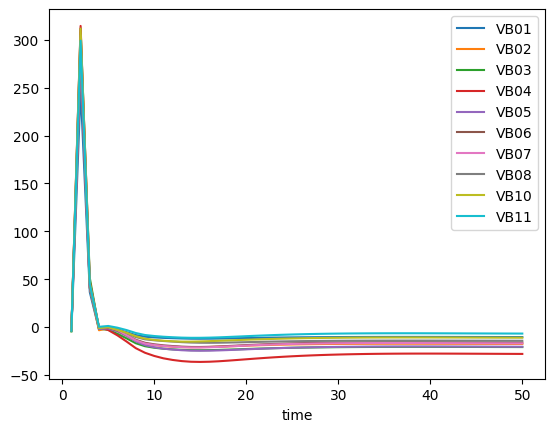

In [429]:
# VD
VD = neurons[['VB01', 'VB02', 'VB03', 'VB04', 'VB05', 'VB06', 'VB07', 'VB08',  'VB10', 'VB11']]
VD_new = VD[(neurons.index > 0) ]
VD_new.plot()